# MNIST CNN Classifier
Adapted from the [mnist_cnn keras example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) pointed to from the [AWS tutorial on containers](https://aws.amazon.com/getting-started/tutorials/train-deep-learning-model-aws-ec2-containers/):
```
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
```

# Setup libraries and parameters

In [1]:
import time
import imageio
import os.path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable

In [3]:
# For confusion matrix and 2D embedding
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

In [4]:
import PIL
import itertools

In [5]:
# Control the resolution of figures plotted below. 200 dpi works well on my macbook
plt.rcParams['figure.dpi'] = 200

In [6]:
# Training settings
class Args:
    batch_size=128
    test_batch_size=1000
    epochs=36
    lr=0.01
    momentum=0.5
    no_cuda=False
    seed=1
    log_interval=117
    save_checkpoints=True
    load_checkpoint=False #'mnist_012.pth'

args = Args

use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Network definition
Adapted from this portion of the Keras example model
```
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
```
A few modifications:
* I changed the first layer to output 8 channels instead of 32, with the rationale being that a 3x3 kernel only spans 9 DOF. Any channels above 9 would start to become linearly dependent, but the nonlinearity after them might allow them to learn more?
* I added batch normalization after the first two convolutional layers because...well...everyone says they are helpful

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        # weights = 1x8x3x3 = 72
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 64, 3, 1)
        # weights = 8x64x3x3 = 4,608
        self.drop1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(12*12*64, 128)
        # weights = 12x12x64x128 = 1,179,648
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        # weights = 128 x 10 = 1280

    def forward(self, x):
        # layer size 28x28x1 = 784
        cl1 = F.relu(self.bn1(self.conv1(x)))
        # layer size 26x26x8 = 5,408
        # perf = 21,632 outputs x 288 kernel entries = 6,230,016 mul adds
        cl2 = F.relu(self.bn2(self.conv2(cl1)))
        # layer size 24x24x64 = 36,864
        # perf = 36,864 outputs x 589,824 kernel entries = 21,743,271,936 mul adds
        mp = F.max_pool2d(cl2, 2, 2)
        # layer size 12x12x64 = 9216
        mp_d = self.drop1(mp)
        # layer size 1x12*12*64 = 9216
        fc1 = F.relu(self.fc1(mp_d.view(-1, 12*12*64)))
        # layer size 1x128
        # perf = 1,179,648 mul adds
        fc2 = self.fc2(self.drop2(fc1))
        # layer size 1x10
        # perf = 1280 mul adds
        return F.log_softmax(fc2, dim=1)
    
    # Output fc1 features
    def features(self, x):
        # layer size 28x28x1 = 784
        cl1 = F.relu(self.bn1(self.conv1(x)))
        # layer size 26x26x8 = 5,408
        # perf = 21,632 outputs x 288 kernel entries = 6,230,016 mul adds
        cl2 = F.relu(self.bn2(self.conv2(cl1)))
        # layer size 24x24x64 = 36,864
        # perf = 36,864 outputs x 589,824 kernel entries = 21,743,271,936 mul adds
        mp = F.max_pool2d(cl2, 2, 2)
        # layer size 12x12x64 = 9216
        mp_d = self.drop1(mp)
        # layer size 1x12*12*64 = 9216
        fc1 = F.relu(self.fc1(mp_d.view(-1, 12*12*64)))
        # layer size 1x128
        # perf = 1,179,648 mul adds
        return fc1

In [8]:
model = Net().to(device)

## Network Graph Plotting
These are the graph of functions back propagated through during the call to backward. This is adapted from the [PyTorch tutorial documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

In [10]:
# depth-first search through the back prop functions
def print_graph(fn, depth=0):
    if fn is None:
        return

    print('|'*depth, type(fn).__name__)
    for i in range(len(fn.next_functions)):
        print_graph(fn.next_functions[i][0], depth+1)

In [11]:
# Generate a random input and run it forward
batch_size = 1
input = torch.randn(batch_size,1,28,28)
output = model(input)

# Run the backward pass, which generates the graph
model.zero_grad()
output.backward(torch.randn(batch_size,10))

# Print the graph
print_graph(output.grad_fn)

 LogSoftmaxBackward
| AddmmBackward
|| AccumulateGrad
|| MulBackward0
||| ReluBackward0
|||| AddmmBackward
||||| AccumulateGrad
||||| ViewBackward
|||||| MulBackward0
||||||| MaxPool2DWithIndicesBackward
|||||||| ReluBackward0
||||||||| NativeBatchNormBackward
|||||||||| MkldnnConvolutionBackward
||||||||||| ReluBackward0
|||||||||||| NativeBatchNormBackward
||||||||||||| MkldnnConvolutionBackward
|||||||||||||| AccumulateGrad
|||||||||||||| AccumulateGrad
||||||||||||| AccumulateGrad
||||||||||||| AccumulateGrad
||||||||||| AccumulateGrad
||||||||||| AccumulateGrad
|||||||||| AccumulateGrad
|||||||||| AccumulateGrad
||||| TBackward
|||||| AccumulateGrad
|| TBackward
||| AccumulateGrad


## Print Model Parameter Sizes
How many weights/parameters are there in each expression (portion of a layer) that contribute to the gradient?

In [12]:
def print_model_size(model):
    total_model_size = 0
    print("Model's state_dict:")
    # print out size of each set of parameter
    for param_tensor in model.state_dict():
        sz = model.state_dict()[param_tensor].size()

        # skip empty parameters (like batch normalization history length)
        if len(sz) == 0:
            continue

        total_model_size += np.prod(sz)
        if len(sz) > 1:
            print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
        else:
            print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))

    # print out total
    print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

In [13]:
 print_model_size(model)

Model's state_dict:
conv1.weight     torch.Size([8, 1, 3, 3])   : 8 x 9 = 72
conv1.bias       torch.Size([8])            : 8
bn1.weight       torch.Size([8])            : 8
bn1.bias         torch.Size([8])            : 8
bn1.running_mean torch.Size([8])            : 8
bn1.running_var  torch.Size([8])            : 8
conv2.weight     torch.Size([64, 8, 3, 3])  : 64 x 72 = 4,608
conv2.bias       torch.Size([64])           : 64
bn2.weight       torch.Size([64])           : 64
bn2.bias         torch.Size([64])           : 64
bn2.running_mean torch.Size([64])           : 64
bn2.running_var  torch.Size([64])           : 64
fc1.weight       torch.Size([128, 9216])    : 128 x 9216 = 1,179,648
fc1.bias         torch.Size([128])          : 128
fc2.weight       torch.Size([10, 128])      : 10 x 128 = 1,280
fc2.bias         torch.Size([10])           : 10

Total Model Size                            : 1,186,106


# DataLoaders|
Wrap dataset downloaders in a DataLoader class

In [14]:
# DataLoaders for train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       #transforms.RandomAffine(10,translate=(0.1,0.1),scale=(0.9,1.1),shear=None,resample=PIL.Image.BILINEAR),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, **kwargs)

# Define the test and training functions

In [15]:
def train(args, model, device, train_loader, optimizer, epoch):
    # Set model to be in training mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{:5}/{} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()/len(data)))

In [16]:
def test(args, model, device, test_loader):
    # Set model to be in testing mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [17]:
def run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch):
    train_start = time.perf_counter()
    train(args, model, device, train_loader, optimizer, epoch)
    train_end = time.perf_counter()
    train_delta = train_end - train_start

    test_start = time.perf_counter()
    test(args, model, device, test_loader)
    test_end = time.perf_counter()
    test_delta = test_end - test_start
    
    print("Training took {:.1f}s.".format(train_delta))
    print("Testing took {:.1f}s.\n".format(test_delta))   

# Checkpointing Logic
This implementation is based on the [PyTorch reference](https://pytorch.org/tutorials/beginner/saving_loading_models.html) 

In [18]:
def save_checkpoint(epoch, filepath='.', prefix='mnist_'):
    checkpoint = {'epoch' : epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict' : optimizer.state_dict(),
                  'loss_criterion' : loss_criterion}
    torch.save(checkpoint, os.path.join(filepath, '{}{:03}.pth'.format(prefix, epoch)))
    
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_criterion = checkpoint['loss_criterion']
    for parameter in model.parameters():
        parameter.requires_grad = False

# Train (or load) the network

### Define the optimizer and loss criterion
I initially ran with SGD, but am now trying Adadelta. I haven't explicitly looked at what the loss is. Here is how Keras was set up:
```
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
```
I've switched to CrossEntropyLoss. I haven't validated that [Keras](https://keras.io/losses/) and [PyTorch](https://pytorch.org/docs/stable/nn.html#crossentropyloss) implement it the same.

In [9]:
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
#optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_criterion = nn.CrossEntropyLoss(reduction='sum')

## Run for 36 epochs
This hits 99.20% (0.0296 average test loss) exactly on epoch 36. It had hit 99.19% on epoch 27, but generally seemed to be around 99.10 to 99.15%

In [19]:
if args.load_checkpoint:
    load_checkpoint(args.load_checkpoint)
    test(args, model, device, test_loader)
else:
    for epoch in range(1, args.epochs + 1):
        run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch)
        if args.save_checkpoints:
            save_checkpoint(epoch)

Train Epoch: 1 [    0/60000 (  0%)]	Loss: 2.320489
Train Epoch: 1 [14976/60000 ( 25%)]	Loss: 0.575745
Train Epoch: 1 [29952/60000 ( 50%)]	Loss: 0.398893
Train Epoch: 1 [44928/60000 ( 75%)]	Loss: 0.328393
Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.164308

Test set: Average loss: 0.1400, Accuracy: 9629/10000 (96%)
Training took 138.9s.
Testing took 10.5s.

Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.286374
Train Epoch: 2 [14976/60000 ( 25%)]	Loss: 0.181885
Train Epoch: 2 [29952/60000 ( 50%)]	Loss: 0.200797
Train Epoch: 2 [44928/60000 ( 75%)]	Loss: 0.196125
Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.107476

Test set: Average loss: 0.0816, Accuracy: 9759/10000 (98%)
Training took 143.6s.
Testing took 10.1s.

Train Epoch: 3 [    0/60000 (  0%)]	Loss: 0.109741
Train Epoch: 3 [14976/60000 ( 25%)]	Loss: 0.074463
Train Epoch: 3 [29952/60000 ( 50%)]	Loss: 0.059418
Train Epoch: 3 [44928/60000 ( 75%)]	Loss: 0.120267
Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.227377

Test set: Average loss: 0.06

Train Epoch: 24 [    0/60000 (  0%)]	Loss: 0.011286
Train Epoch: 24 [14976/60000 ( 25%)]	Loss: 0.020784
Train Epoch: 24 [29952/60000 ( 50%)]	Loss: 0.001645
Train Epoch: 24 [44928/60000 ( 75%)]	Loss: 0.014198
Train Epoch: 24 [44928/60000 (100%)]	Loss: 0.019253

Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99%)
Training took 285.7s.
Testing took 22.2s.

Train Epoch: 25 [    0/60000 (  0%)]	Loss: 0.010913
Train Epoch: 25 [14976/60000 ( 25%)]	Loss: 0.009568
Train Epoch: 25 [29952/60000 ( 50%)]	Loss: 0.017464
Train Epoch: 25 [44928/60000 ( 75%)]	Loss: 0.006518
Train Epoch: 25 [44928/60000 (100%)]	Loss: 0.042685

Test set: Average loss: 0.0289, Accuracy: 9905/10000 (99%)
Training took 284.7s.
Testing took 22.2s.

Train Epoch: 26 [    0/60000 (  0%)]	Loss: 0.019446
Train Epoch: 26 [14976/60000 ( 25%)]	Loss: 0.009703
Train Epoch: 26 [29952/60000 ( 50%)]	Loss: 0.034450
Train Epoch: 26 [44928/60000 ( 75%)]	Loss: 0.025420
Train Epoch: 26 [44928/60000 (100%)]	Loss: 0.025176

Test set: Ave

## Run for another 36 epochs
This hits 99.24% on epoch 60 (0.0302 average test loss), but bounces around between 99.00% and 99.20% mostly

In [20]:
if args.load_checkpoint:
    load_checkpoint(args.load_checkpoint)
    test(args, model, device, test_loader)
else:
    for epoch in range(args.epochs + 1, 2*args.epochs + 1):
        run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch)
        if args.save_checkpoints:
            save_checkpoint(epoch)

Train Epoch: 37 [    0/60000 (  0%)]	Loss: 0.010662
Train Epoch: 37 [14976/60000 ( 25%)]	Loss: 0.021255
Train Epoch: 37 [29952/60000 ( 50%)]	Loss: 0.004721
Train Epoch: 37 [44928/60000 ( 75%)]	Loss: 0.005917
Train Epoch: 37 [44928/60000 (100%)]	Loss: 0.008538

Test set: Average loss: 0.0306, Accuracy: 9906/10000 (99%)
Training took 286.6s.
Testing took 22.2s.

Train Epoch: 38 [    0/60000 (  0%)]	Loss: 0.007224
Train Epoch: 38 [14976/60000 ( 25%)]	Loss: 0.020785
Train Epoch: 38 [29952/60000 ( 50%)]	Loss: 0.001651
Train Epoch: 38 [44928/60000 ( 75%)]	Loss: 0.001801
Train Epoch: 38 [44928/60000 (100%)]	Loss: 0.014999

Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99%)
Training took 284.2s.
Testing took 14.1s.

Train Epoch: 39 [    0/60000 (  0%)]	Loss: 0.005467
Train Epoch: 39 [14976/60000 ( 25%)]	Loss: 0.014093
Train Epoch: 39 [29952/60000 ( 50%)]	Loss: 0.002701
Train Epoch: 39 [44928/60000 ( 75%)]	Loss: 0.028670
Train Epoch: 39 [44928/60000 (100%)]	Loss: 0.002639

Test set: Ave


Test set: Average loss: 0.0313, Accuracy: 9924/10000 (99%)
Training took 129.7s.
Testing took 9.4s.

Train Epoch: 60 [    0/60000 (  0%)]	Loss: 0.006100
Train Epoch: 60 [14976/60000 ( 25%)]	Loss: 0.002180
Train Epoch: 60 [29952/60000 ( 50%)]	Loss: 0.000500
Train Epoch: 60 [44928/60000 ( 75%)]	Loss: 0.030575
Train Epoch: 60 [44928/60000 (100%)]	Loss: 0.001261

Test set: Average loss: 0.0302, Accuracy: 9924/10000 (99%)
Training took 129.7s.
Testing took 9.4s.

Train Epoch: 61 [    0/60000 (  0%)]	Loss: 0.005337
Train Epoch: 61 [14976/60000 ( 25%)]	Loss: 0.001279
Train Epoch: 61 [29952/60000 ( 50%)]	Loss: 0.003085
Train Epoch: 61 [44928/60000 ( 75%)]	Loss: 0.011225
Train Epoch: 61 [44928/60000 (100%)]	Loss: 0.011342

Test set: Average loss: 0.0302, Accuracy: 9915/10000 (99%)
Training took 131.3s.
Testing took 9.4s.

Train Epoch: 62 [    0/60000 (  0%)]	Loss: 0.009157
Train Epoch: 62 [14976/60000 ( 25%)]	Loss: 0.003518
Train Epoch: 62 [29952/60000 ( 50%)]	Loss: 0.001910
Train Epoch: 62 [4

## Turn on data augmentation and run for another 36 epochs
With data augmentation, we hit 99.35% accuracy below (0.0208 average test loss) on epoch 107. It still seems to be slowly making progress.

In [44]:
# DataLoaders for train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.RandomAffine(10,translate=(0.1,0.1),scale=(0.9,1.1),shear=None,resample=PIL.Image.BILINEAR),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

In [45]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_criterion = nn.CrossEntropyLoss(reduction='sum')

In [46]:
if args.load_checkpoint:
    load_checkpoint(args.load_checkpoint)
    test(args, model, device, test_loader)
else:
    for epoch in range(2*args.epochs + 1, 3*args.epochs + 1):
        run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch)
        if args.save_checkpoints:
            save_checkpoint(epoch)

Train Epoch: 73 [    0/60000 (  0%)]	Loss: 0.986198
Train Epoch: 73 [14976/60000 ( 25%)]	Loss: 0.254535
Train Epoch: 73 [29952/60000 ( 50%)]	Loss: 0.308302
Train Epoch: 73 [44928/60000 ( 75%)]	Loss: 0.272637
Train Epoch: 73 [44928/60000 (100%)]	Loss: 0.287662

Test set: Average loss: 0.0341, Accuracy: 9890/10000 (99%)
Training took 134.9s.
Testing took 11.8s.

Train Epoch: 74 [    0/60000 (  0%)]	Loss: 0.309138
Train Epoch: 74 [14976/60000 ( 25%)]	Loss: 0.189091
Train Epoch: 74 [29952/60000 ( 50%)]	Loss: 0.150145
Train Epoch: 74 [44928/60000 ( 75%)]	Loss: 0.138289
Train Epoch: 74 [44928/60000 (100%)]	Loss: 0.172653

Test set: Average loss: 0.0312, Accuracy: 9899/10000 (99%)
Training took 144.9s.
Testing took 10.7s.

Train Epoch: 75 [    0/60000 (  0%)]	Loss: 0.314445
Train Epoch: 75 [14976/60000 ( 25%)]	Loss: 0.205041
Train Epoch: 75 [29952/60000 ( 50%)]	Loss: 0.278214
Train Epoch: 75 [44928/60000 ( 75%)]	Loss: 0.410812
Train Epoch: 75 [44928/60000 (100%)]	Loss: 0.090867

Test set: Ave


Test set: Average loss: 0.0236, Accuracy: 9917/10000 (99%)
Training took 225.3s.
Testing took 20.7s.

Train Epoch: 96 [    0/60000 (  0%)]	Loss: 0.159004
Train Epoch: 96 [14976/60000 ( 25%)]	Loss: 0.093330
Train Epoch: 96 [29952/60000 ( 50%)]	Loss: 0.063101
Train Epoch: 96 [44928/60000 ( 75%)]	Loss: 0.047395
Train Epoch: 96 [44928/60000 (100%)]	Loss: 0.107466

Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99%)
Training took 165.2s.
Testing took 9.5s.

Train Epoch: 97 [    0/60000 (  0%)]	Loss: 0.095910
Train Epoch: 97 [14976/60000 ( 25%)]	Loss: 0.072535
Train Epoch: 97 [29952/60000 ( 50%)]	Loss: 0.098918
Train Epoch: 97 [44928/60000 ( 75%)]	Loss: 0.101451
Train Epoch: 97 [44928/60000 (100%)]	Loss: 0.136940

Test set: Average loss: 0.0232, Accuracy: 9922/10000 (99%)
Training took 137.4s.
Testing took 9.5s.

Train Epoch: 98 [    0/60000 (  0%)]	Loss: 0.091660
Train Epoch: 98 [14976/60000 ( 25%)]	Loss: 0.098449
Train Epoch: 98 [29952/60000 ( 50%)]	Loss: 0.251848
Train Epoch: 98 [

## Run for another 36 epochs with augmentation on
Data augmentation helped, so lets run for another 36 with it on and see what happens

Epoch 115 hit 99.36% accuracy with 0.0192 average test loss

Epoch 116 hit 99.37% accuracy with 0.0210 average test loss

Through epoch 143, it's mostly stabilized to around 99.30%

In [47]:
if args.load_checkpoint:
    load_checkpoint(args.load_checkpoint)
    test(args, model, device, test_loader)
else:
    for epoch in range(3*args.epochs + 1, 4*args.epochs + 1):
        run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch)
        if args.save_checkpoints:
            save_checkpoint(epoch)

Train Epoch: 109 [    0/60000 (  0%)]	Loss: 0.027605
Train Epoch: 109 [14976/60000 ( 25%)]	Loss: 0.103075
Train Epoch: 109 [29952/60000 ( 50%)]	Loss: 0.059637
Train Epoch: 109 [44928/60000 ( 75%)]	Loss: 0.110098
Train Epoch: 109 [44928/60000 (100%)]	Loss: 0.020021

Test set: Average loss: 0.0214, Accuracy: 9928/10000 (99%)
Training took 143.9s.
Testing took 9.5s.

Train Epoch: 110 [    0/60000 (  0%)]	Loss: 0.043845
Train Epoch: 110 [14976/60000 ( 25%)]	Loss: 0.092831
Train Epoch: 110 [29952/60000 ( 50%)]	Loss: 0.156322
Train Epoch: 110 [44928/60000 ( 75%)]	Loss: 0.040827
Train Epoch: 110 [44928/60000 (100%)]	Loss: 0.056780

Test set: Average loss: 0.0226, Accuracy: 9915/10000 (99%)
Training took 148.9s.
Testing took 11.7s.

Train Epoch: 111 [    0/60000 (  0%)]	Loss: 0.049561
Train Epoch: 111 [14976/60000 ( 25%)]	Loss: 0.124571
Train Epoch: 111 [29952/60000 ( 50%)]	Loss: 0.055293
Train Epoch: 111 [44928/60000 ( 75%)]	Loss: 0.129275
Train Epoch: 111 [44928/60000 (100%)]	Loss: 0.031248


Train Epoch: 131 [44928/60000 ( 75%)]	Loss: 0.119006
Train Epoch: 131 [44928/60000 (100%)]	Loss: 0.039168

Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99%)
Training took 149.2s.
Testing took 10.3s.

Train Epoch: 132 [    0/60000 (  0%)]	Loss: 0.057753
Train Epoch: 132 [14976/60000 ( 25%)]	Loss: 0.069333
Train Epoch: 132 [29952/60000 ( 50%)]	Loss: 0.080321
Train Epoch: 132 [44928/60000 ( 75%)]	Loss: 0.152475
Train Epoch: 132 [44928/60000 (100%)]	Loss: 0.057617

Test set: Average loss: 0.0207, Accuracy: 9924/10000 (99%)
Training took 142.1s.
Testing took 9.6s.

Train Epoch: 133 [    0/60000 (  0%)]	Loss: 0.088412
Train Epoch: 133 [14976/60000 ( 25%)]	Loss: 0.066928
Train Epoch: 133 [29952/60000 ( 50%)]	Loss: 0.072286
Train Epoch: 133 [44928/60000 ( 75%)]	Loss: 0.029813
Train Epoch: 133 [44928/60000 (100%)]	Loss: 0.064654

Test set: Average loss: 0.0208, Accuracy: 9926/10000 (99%)
Training took 137.3s.
Testing took 9.5s.

Train Epoch: 134 [    0/60000 (  0%)]	Loss: 0.054232
Trai

# Visualization Code

## Create a 2800 x 2800 tiled image from the 10,000 test images

In [48]:
def tile_digits(digits, outputs=None, shape='Square', train=False):
    ds = datasets.MNIST('../data', train=train, transform=transforms.Compose([
                           transforms.ToTensor()]))

    cmap = mpl.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)
    
    def get_img(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < -10:
            return np.zeros((28,28,3)).astype('uint8')
        
        idx = digits[idx]
        if idx < 0:
            clr = cmap(-idx-1)
            img = np.full((28,28,1), 255)
        else:
            clr = cmap(ds[idx][1])
            img = ds[idx][0].numpy().reshape(28,28)*255
            
        return np.dstack([(img*clr[c]).astype('uint8') for c in range(3)])

    def get_target(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < 0:
            return -1
        return ds[digits[idx]][1]

    def get_class(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < 0:
            return -1
        return outputs[digits[idx]].argmax(dim=0, keepdim=True).numpy().T[0]

    cnt = len(digits)
    if shape is 'Square':
        cols = np.ceil(np.sqrt(cnt)).astype('int64')
    elif shape is 'Horizontal':
        cols = cnt
    else:
        cols = 1

    img = np.vstack([np.hstack([get_img(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])
    targets = np.vstack([np.hstack([get_target(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])
    if outputs is None:
        return img, targets
    else:
        classes = np.vstack([np.hstack([get_class(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])

    return img, targets, classes

In [49]:
tiled, target = tile_digits(range(10000))
imageio.imwrite('tiled.png', tiled)

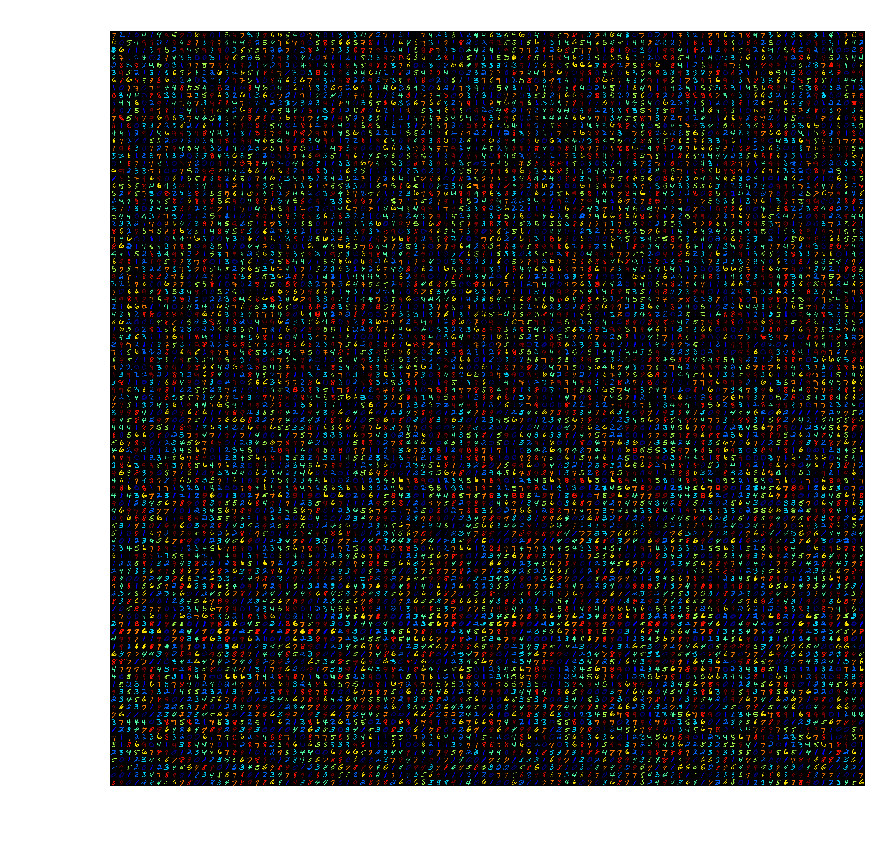

In [50]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(tiled)
plt.show()

## Inspect Failures

In [51]:
def get_failures(model, device, test_loader):
    model.eval()

    batch_offset = 0
    failure_indices = []
    target_all = torch.zeros((0),dtype=torch.long)
    output_all = torch.zeros((0,10))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            target_all = torch.cat((target_all, target))
            output_all = torch.cat((output_all, output))

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            idx = np.where(pred.ne(target.view_as(pred)))[0]
            failure_indices += list(idx + batch_offset)
            
            batch_offset += pred.size(0)
    return np.array(failure_indices), output_all, target_all

In [52]:
failure_indices, output_all, target_all = get_failures(model, device, test_loader)

In [53]:
target_failures = target_all[failure_indices]
failure_idx_by_digit = list(map(lambda digit: np.where(target_failures.eq(digit))[0], range(0,10)))

# Print sorted failures
sorted_failures = np.hstack(failure_idx_by_digit)
fail_img, targets, classes = tile_digits(failure_indices[sorted_failures], output_all)

print(len(failure_indices))
print('Classifications:\n', classes)
imageio.imwrite('sorted_failures.png', fail_img)


66
Classifications:
 [[ 7  2  7  7  3  2  7  6  7]
 [ 0  7  7  8  2  8  6  9  8]
 [ 9  9  3  3  3  8  6  0  5]
 [ 8  5  1  0  4  8  5  1  5]
 [ 1  1  1  2  8  1  9  2  2]
 [ 2  8  8  4  8  4  3  4  4]
 [ 8  5  5  5  8  4  3  8  3]
 [ 7  7  7 -1 -1 -1 -1 -1 -1]]


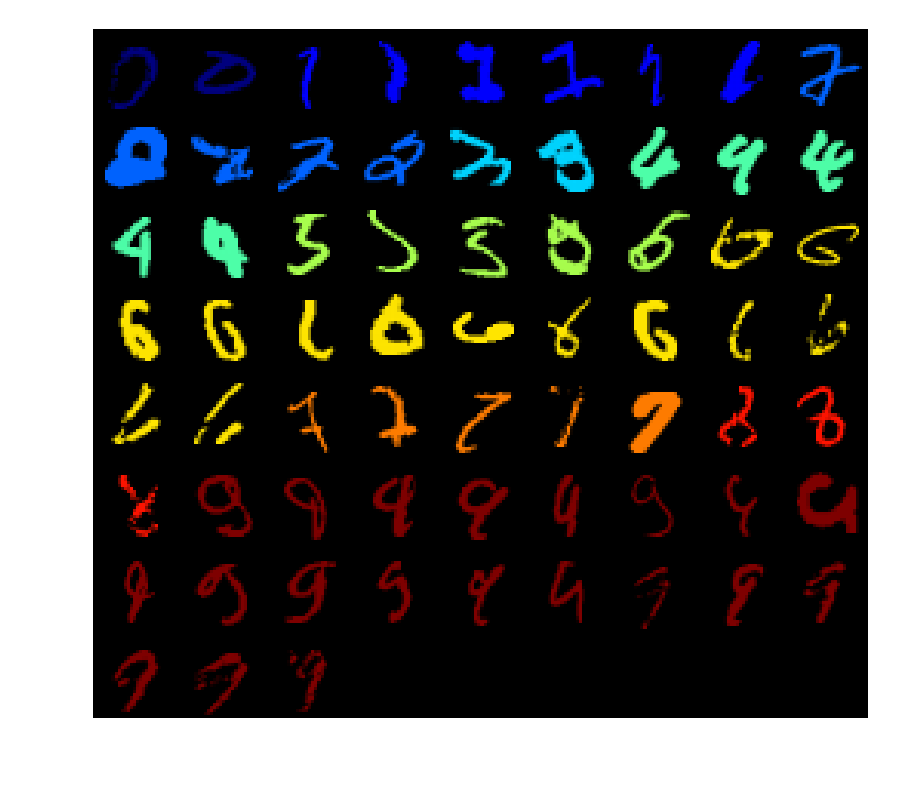

In [54]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(fail_img)
plt.show()

## Plot t-SNE embedding of fc1 features
First extract the fc1 features for each test image and their ground truth values

In [55]:
def get_fc1_features(model, device, dataloader):
    # Set model to be in testing mode
    model.eval()
    with torch.no_grad():
        x = list(map(lambda x: (model.features(x[0].to(device)), x[1].to(device)), dataloader))
        fc1 = torch.cat(list(map(lambda x: x[0], x))).detach().numpy()
        target = torch.cat(list(map(lambda x: x[1], x))).detach().numpy()
        return fc1, target

In [56]:
fc1, target=get_fc1_features(model, device, test_loader)

Embed the 128 dimensional fc1 features in 2D space

In [57]:
X_embedded = TSNE(n_components=2).fit_transform(fc1)

Plot the 2D embedding, color-coded by the ground truth value

10000

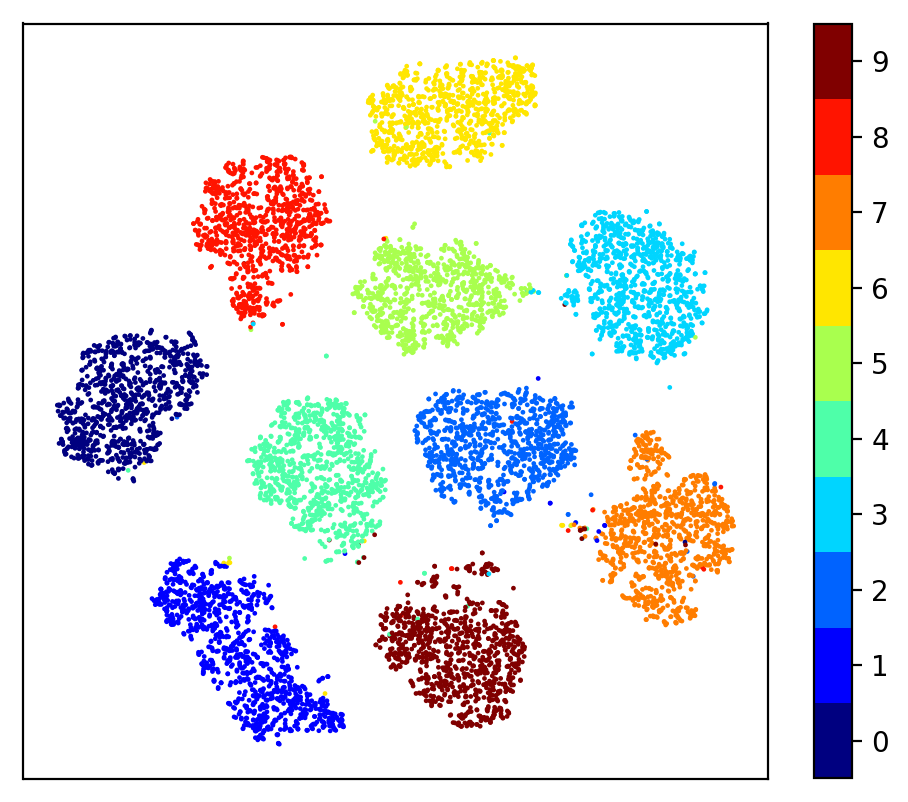

In [58]:
cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

#def onclick(event):
#    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
#          ('double' if event.dblclick else 'single', event.button,
#           event.x, event.y, event.xdata, event.ydata))

fig, (ax0) = plt.subplots(1,1, figsize=(6,5), dpi=200)

#cid = fig.canvas.mpl_connect('button_release_event', onclick)

cs=ax0.scatter(X_embedded[:,0], X_embedded[:,1],
               norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5),
               s=.5, c=target, cmap=cmap)

cb = plt.colorbar(cs, ax=ax0)
cb.set_ticks(np.arange(0,10))
cb.set_ticklabels(np.arange(0, 10))

ax0.set_xticks([])
ax0.set_yticks([])


#ax[1].set_xticks([])
#ax[1].set_yticks([])


len(target)

### How about just 4, 7 and 9

In [59]:
lst = [4,7,9]
fc1_sub=fc1[np.isin(target,lst),:]
target_sub=target[np.isin(target,lst)]

In [60]:
X_embedded_sub = TSNE(n_components=2).fit_transform(fc1_sub)

3019

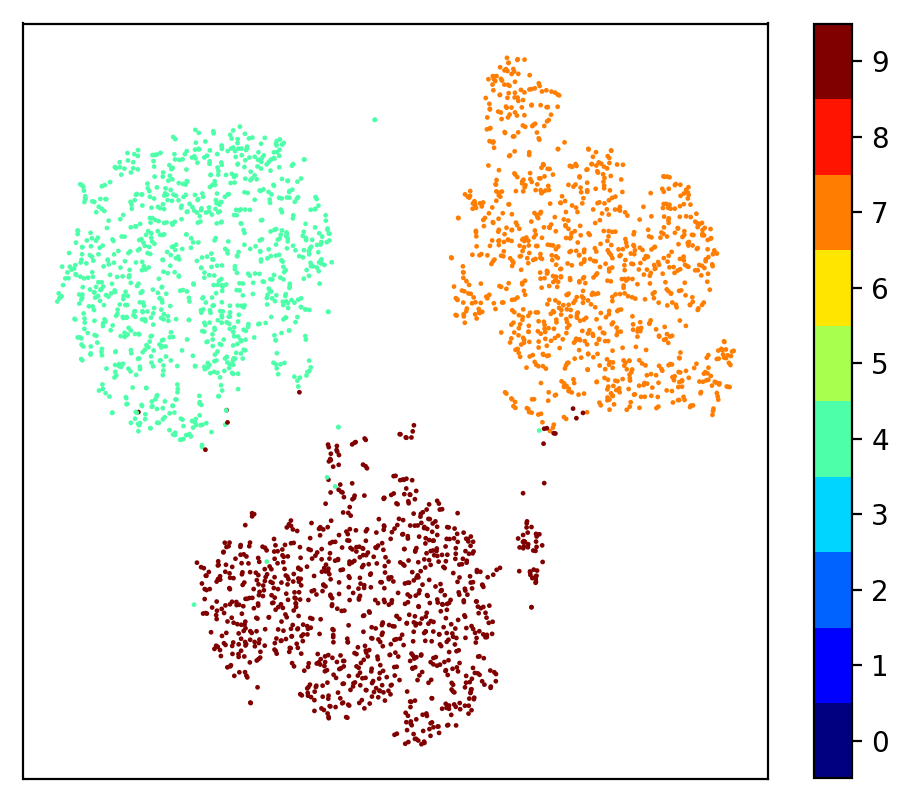

In [61]:
fig, (ax0) = plt.subplots(1,1, figsize=(6,5), dpi=200)

cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

cs=plt.scatter(X_embedded_sub[:,0], X_embedded_sub[:,1], s=.5, c=target_sub, cmap=cmap, norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5))
cb = plt.colorbar(cs)
cb.set_ticks(np.arange(0,10))
cb.set_ticklabels(np.arange(0, 10))

ax0.set_xticks([])
ax0.set_yticks([])
len(target_sub)

## What are the Nearest Neighbors for Failures?

In [62]:
# DataLoaders for train and test data
train_loader_fc1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=False, **kwargs)

train_fc1, train_target=get_fc1_features(model, device, train_loader_fc1)

In [63]:
nbrs = NearestNeighbors(n_neighbors=16, algorithm='ball_tree').fit(train_fc1)
distances, indices = nbrs.kneighbors(fc1[failure_indices[sorted_failures],:])

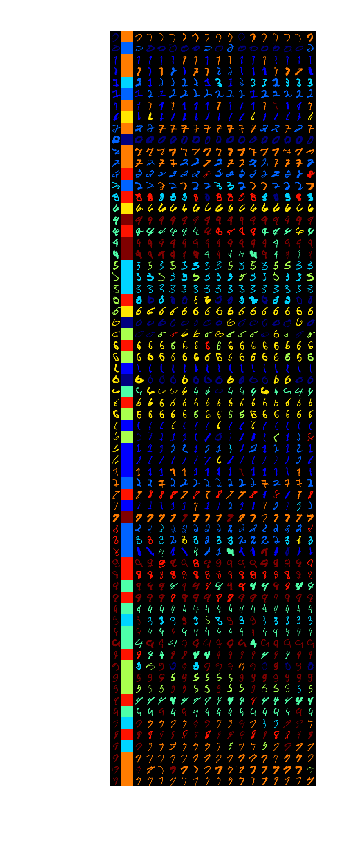

In [64]:
cnt = len(sorted_failures)

failure_classes = output_all[failure_indices[sorted_failures]].argmax(dim=1, keepdim=True) # get the index of the max log-probability

failure_img = tile_digits(failure_indices[sorted_failures], shape='Vertical')[0]
failure_classification_img = tile_digits((-failure_classes.numpy()-1).transpose()[0], shape='Vertical')[0]
neigh_img = np.vstack([tile_digits(indices[idx,:], shape='Horizontal', train=True)[0] for idx in range(cnt)])

imageio.imwrite('neighbors_train.png', np.hstack([failure_img, failure_classification_img, neigh_img]))

fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
ax.imshow(np.hstack([failure_img, failure_classification_img, neigh_img]))

plt.show()

## Plot Confusion Matrix
The confusion matrix plotting function was copied from [Yassine Ghouzam's great notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

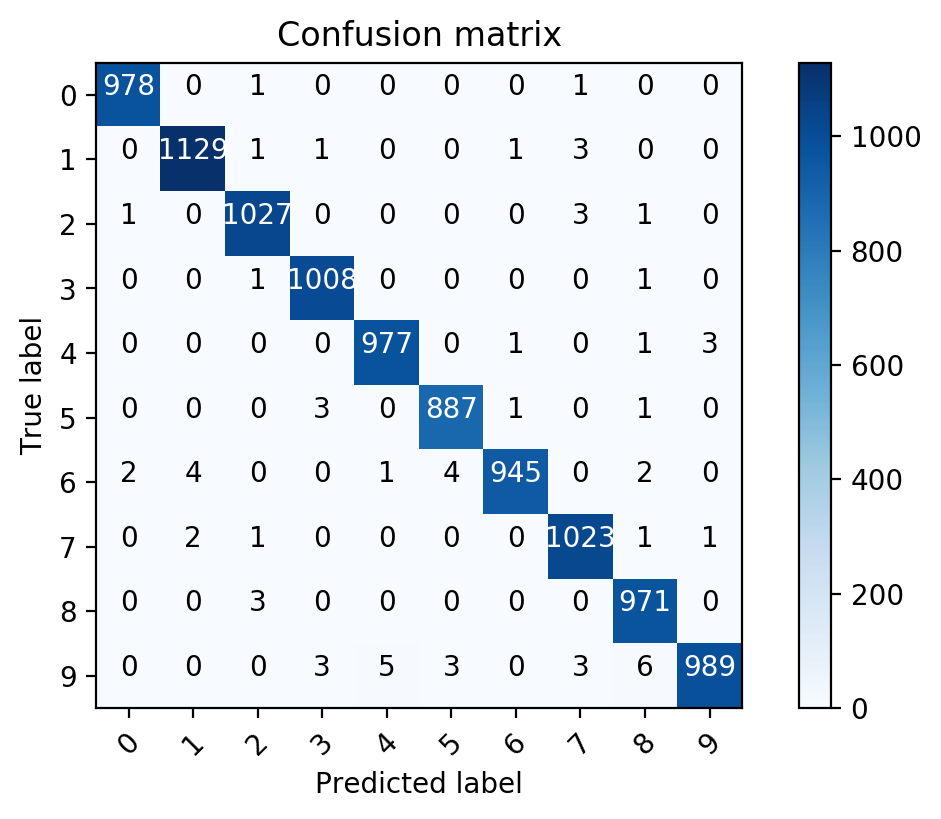

In [66]:
pred_all = output_all.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
# compute the confusion matrix
confusion_mtx = confusion_matrix(target_all, pred_all) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Look at weights/kernels

In [67]:
def plot_kernels(conv_layer):
    out_dim = conv_layer.size()[0]
    in_dim = conv_layer.size()[1]
    kw = conv_layer.size()[2]
    kh = conv_layer.size()[3]
    #np.linalg.svd()

    for row in range(0,out_dim):
        fig, ax = plt.subplots(1, in_dim)
        for col in range(0,in_dim):
            if in_dim>1:
                col_ax = ax[col]
            else:
                col_ax = ax
            col_ax.imshow(conv_layer[row][col].numpy(), cmap='binary')
            col_ax.axis('off')
        plt.show()

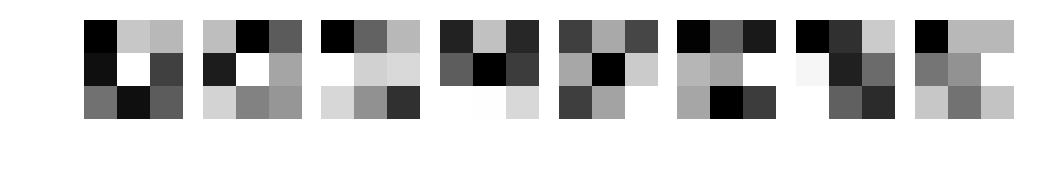

In [68]:
plot_kernels(model.state_dict()['conv1.weight'].permute(1,0,2,3))

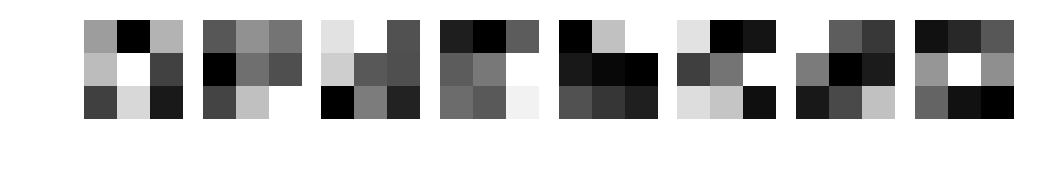

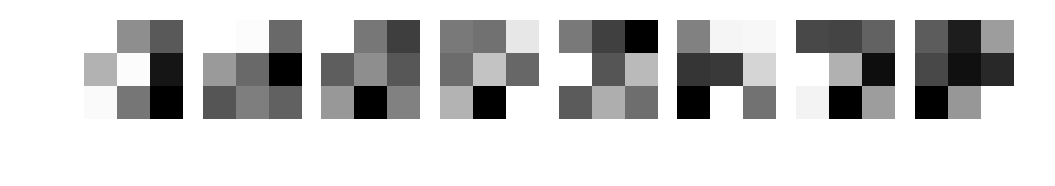

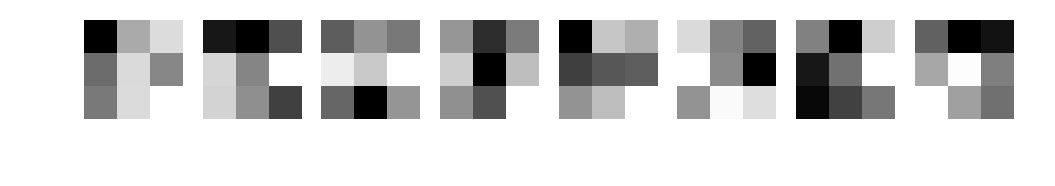

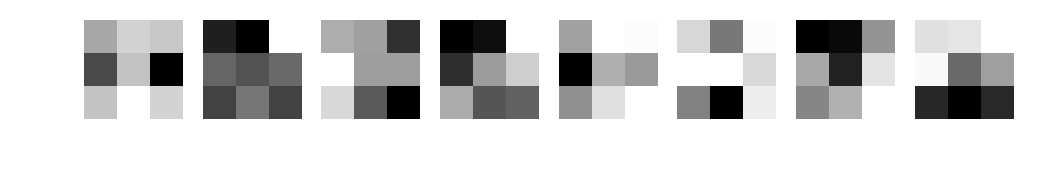

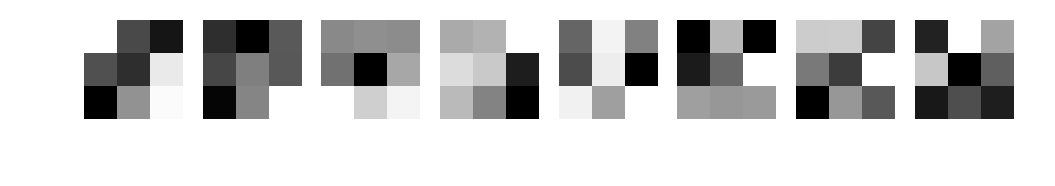

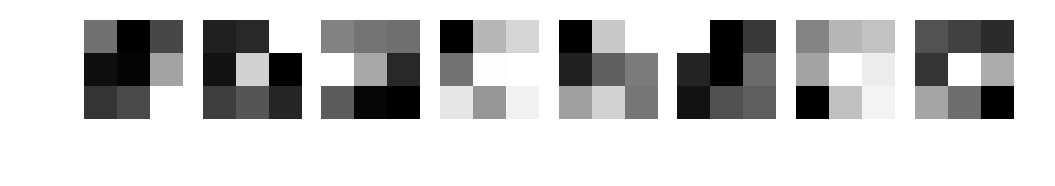

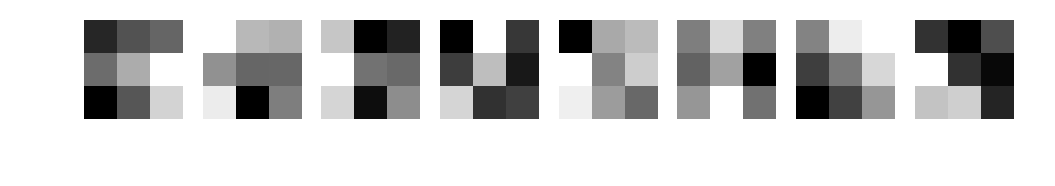

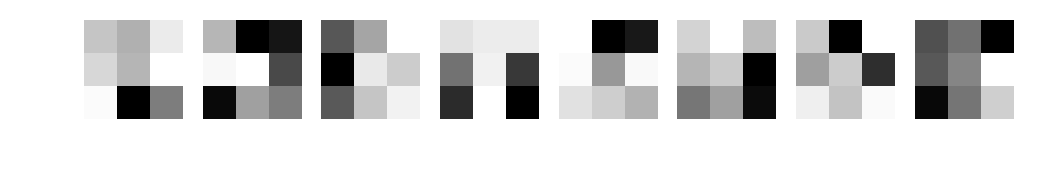

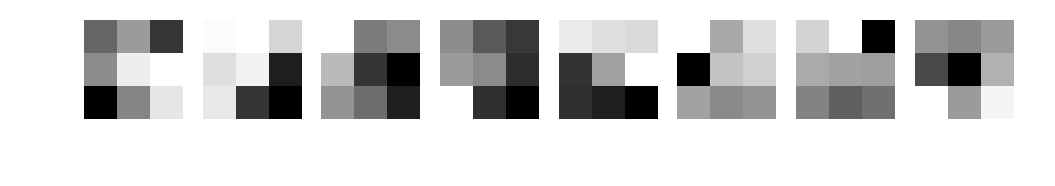

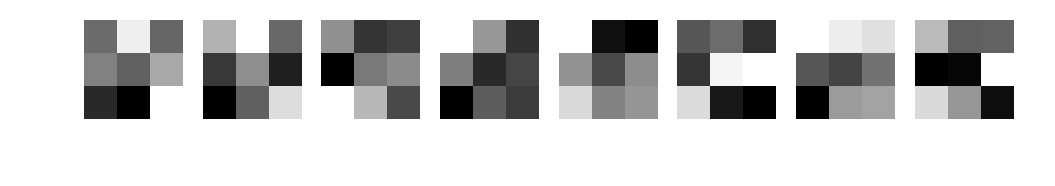

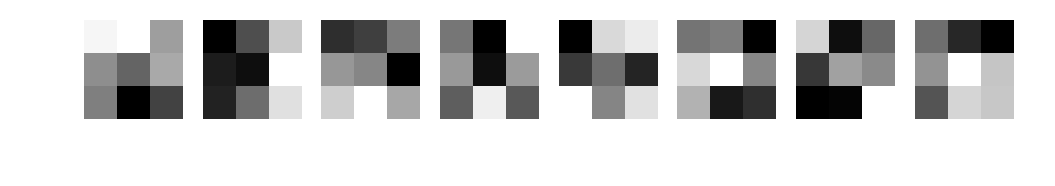

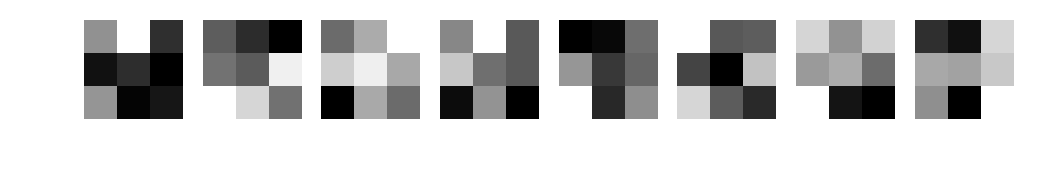

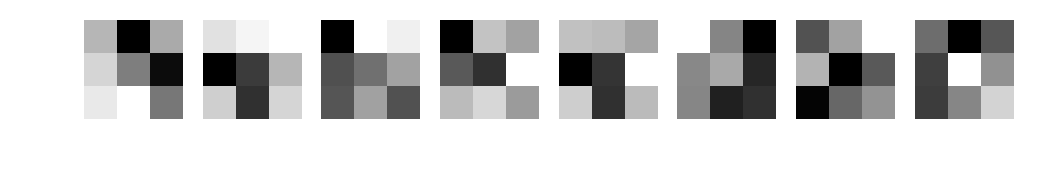

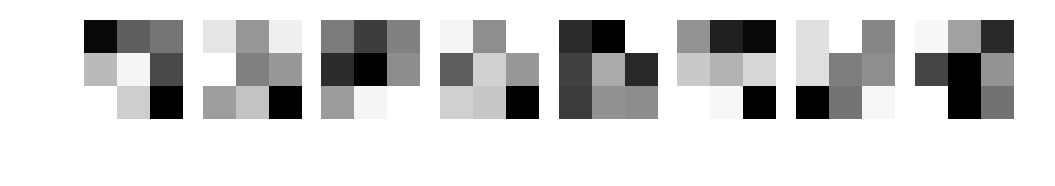

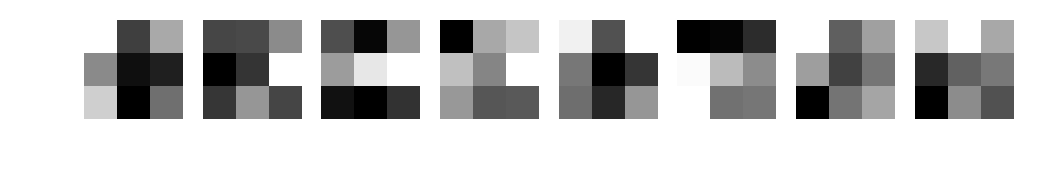

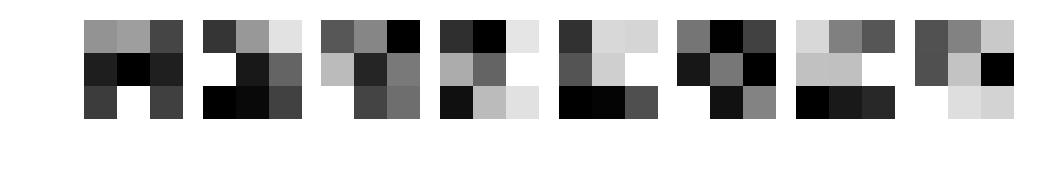

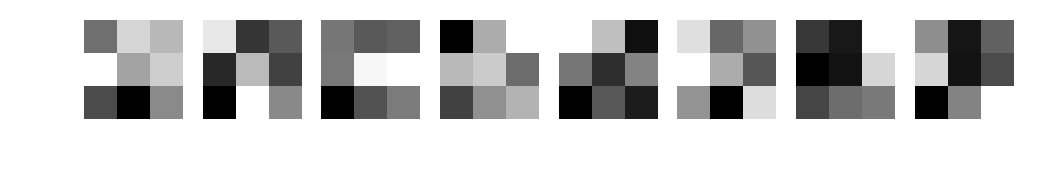

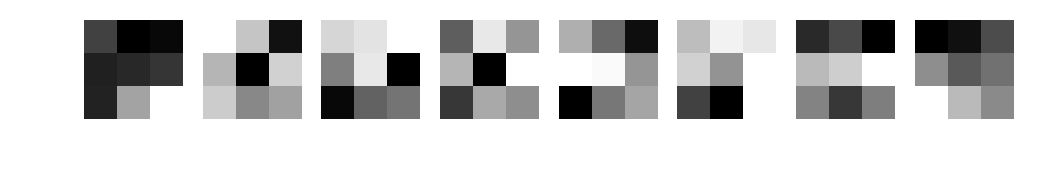

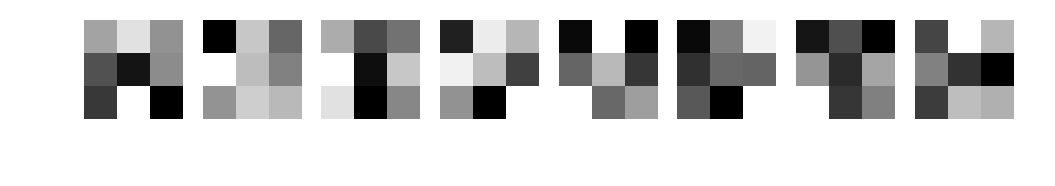

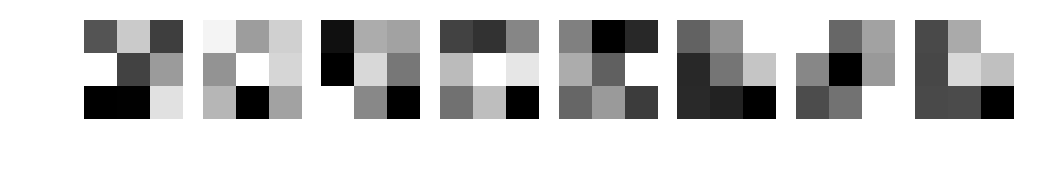

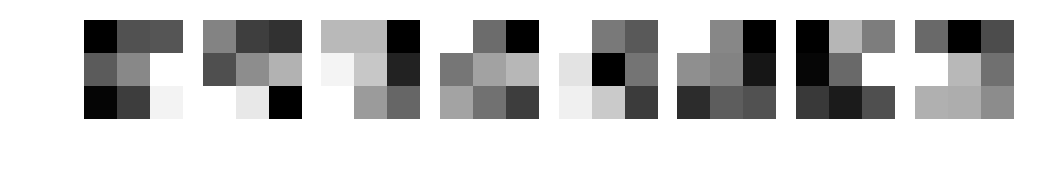

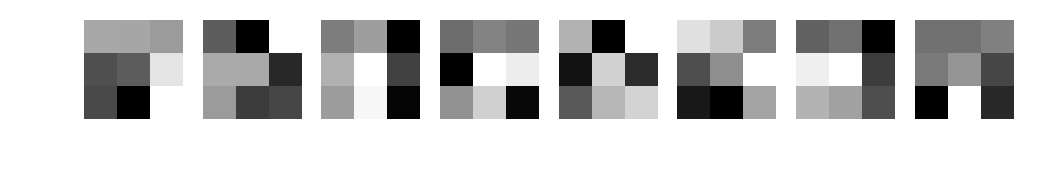

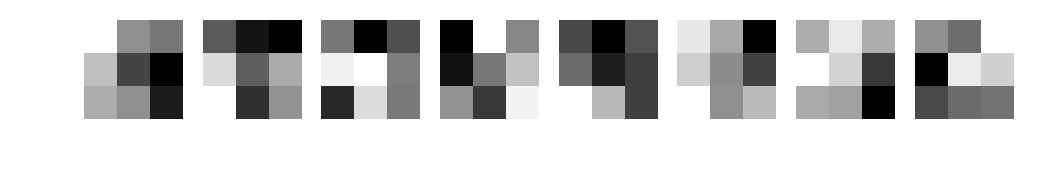

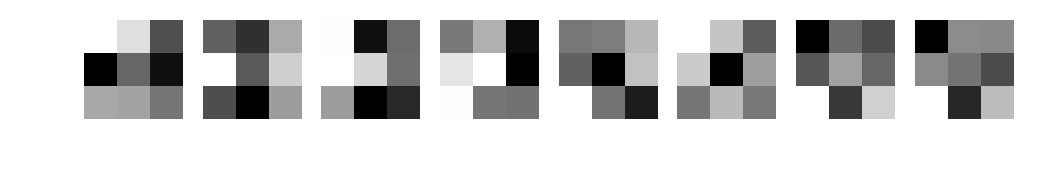

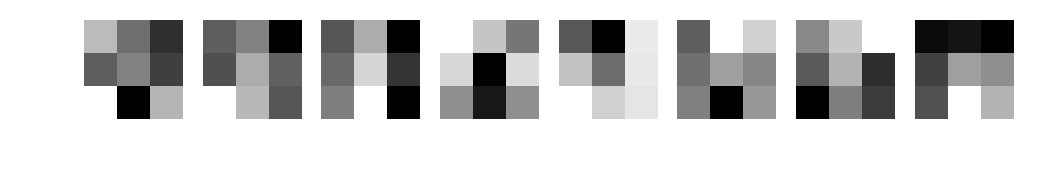

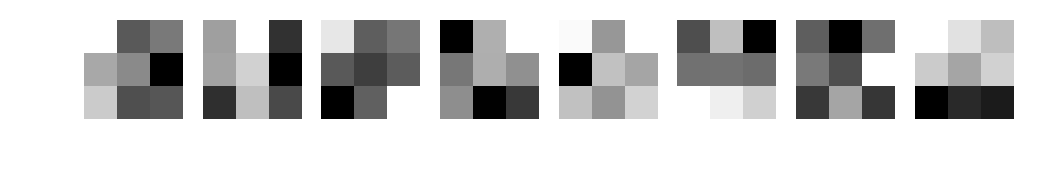

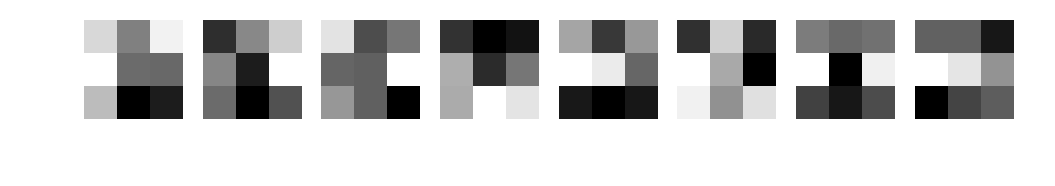

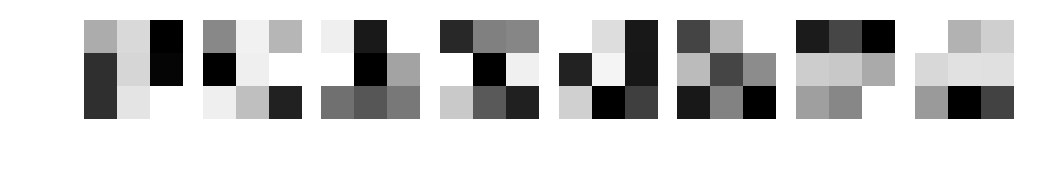

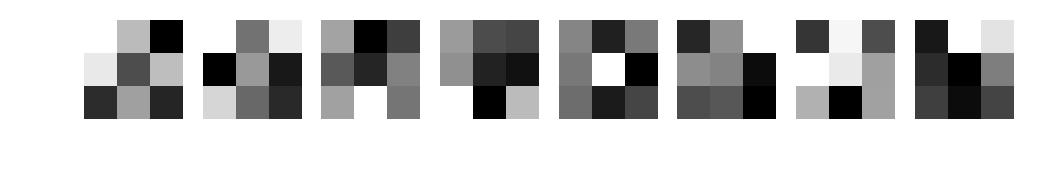

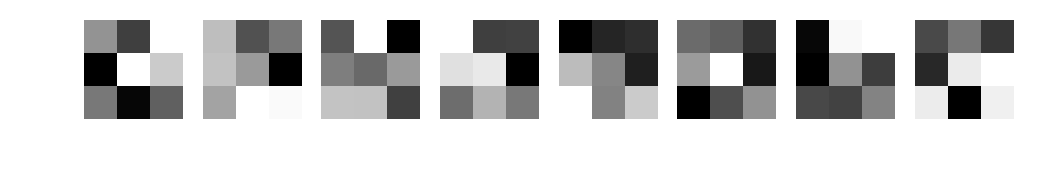

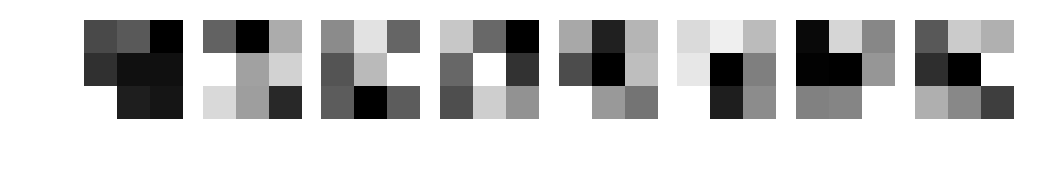

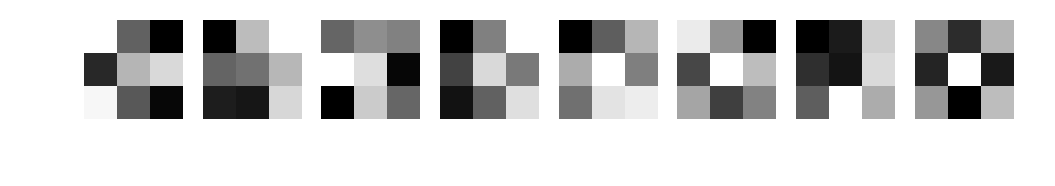

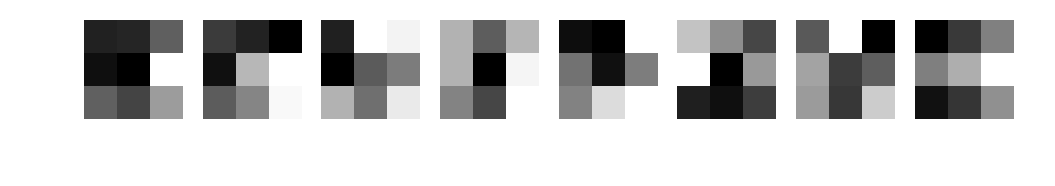

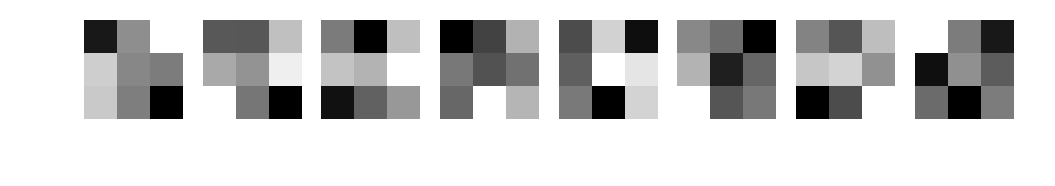

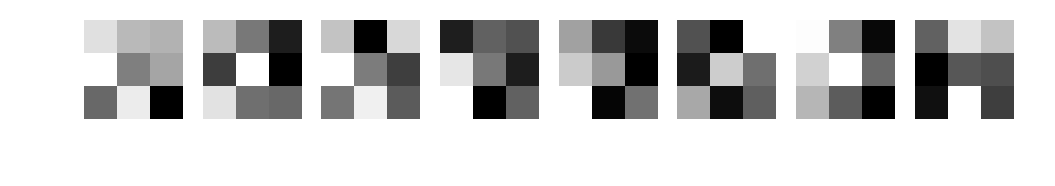

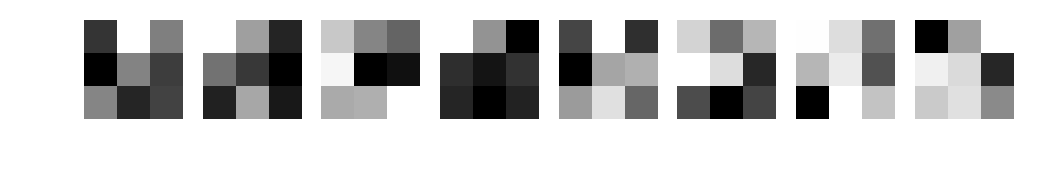

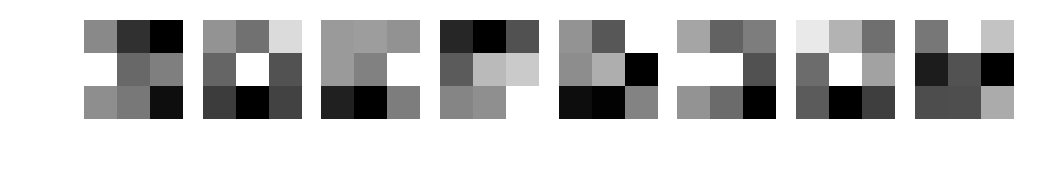

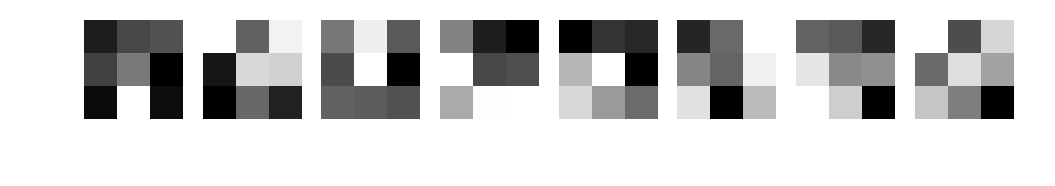

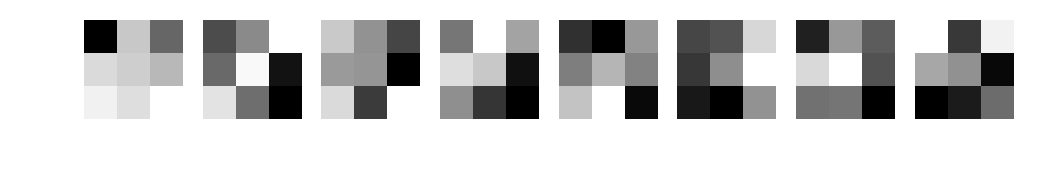

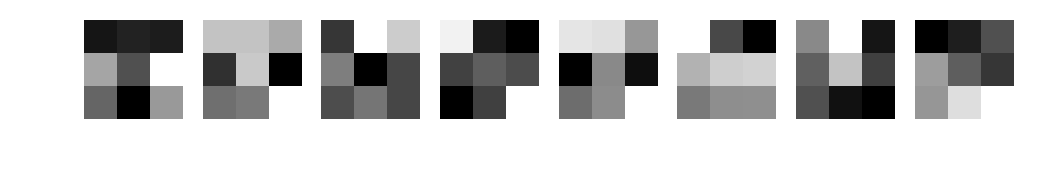

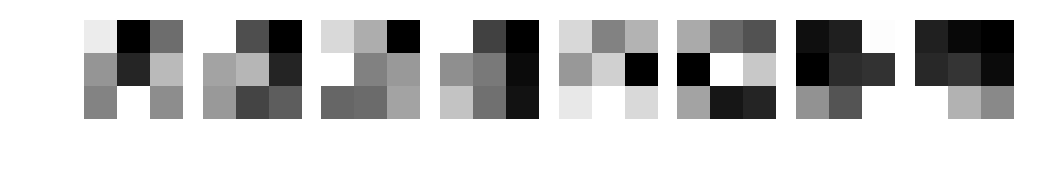

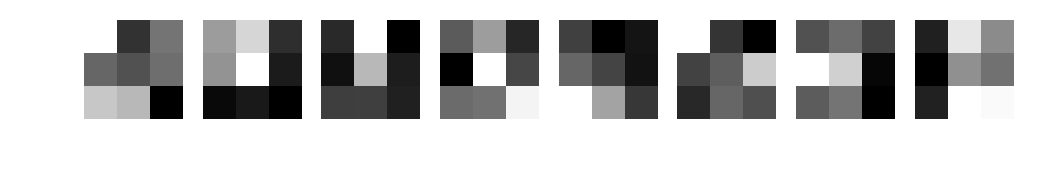

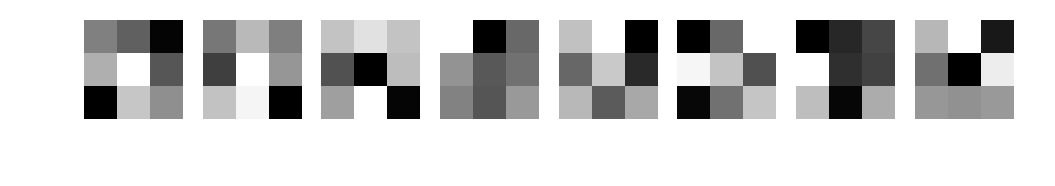

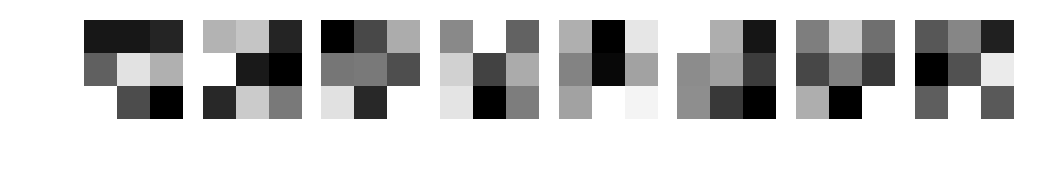

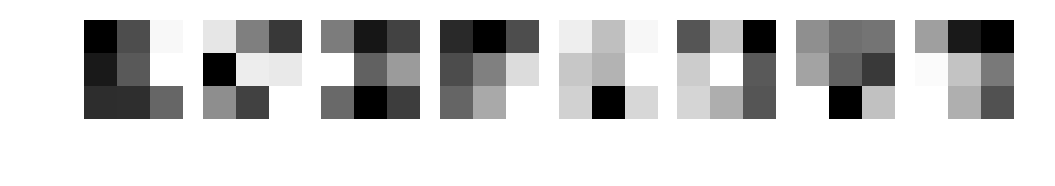

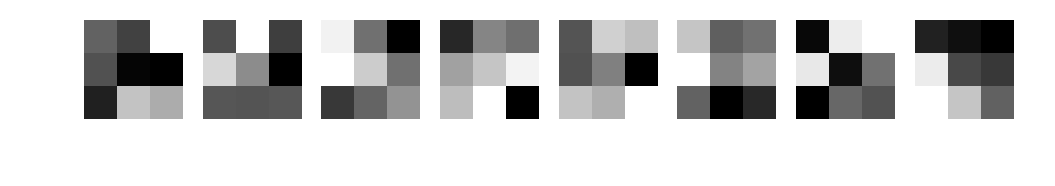

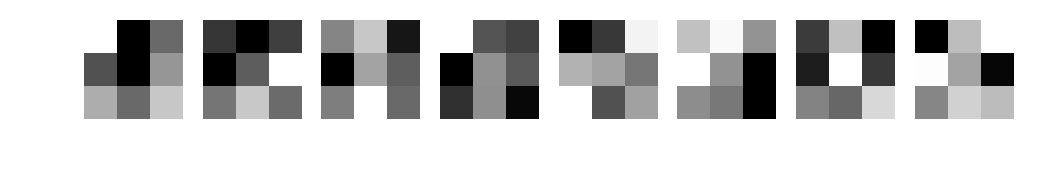

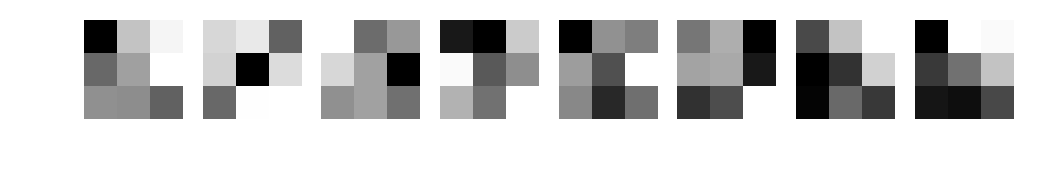

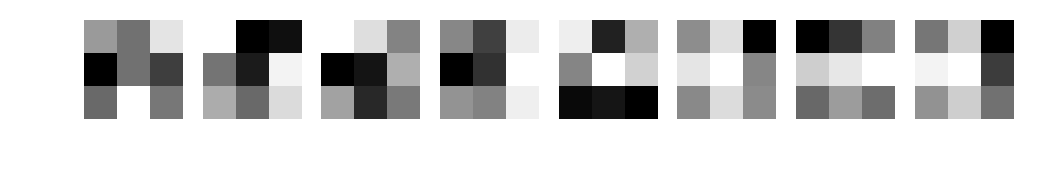

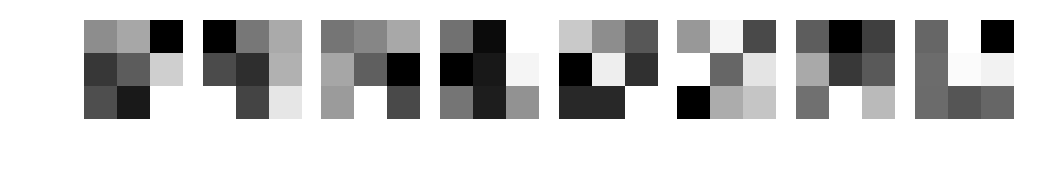

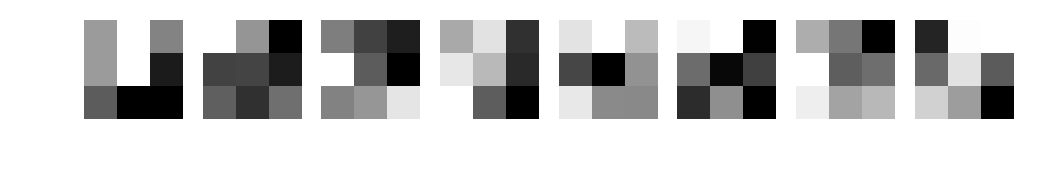

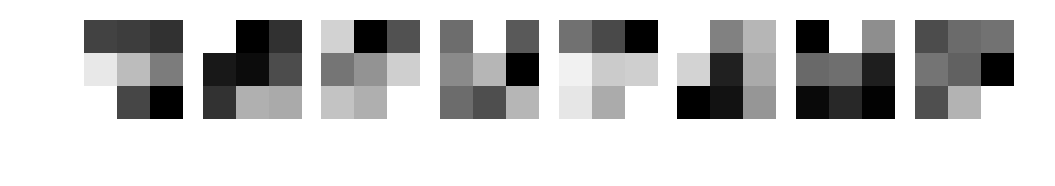

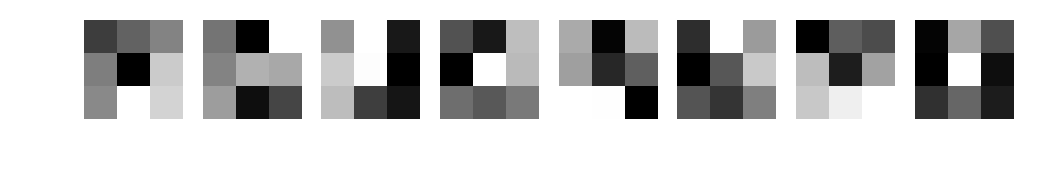

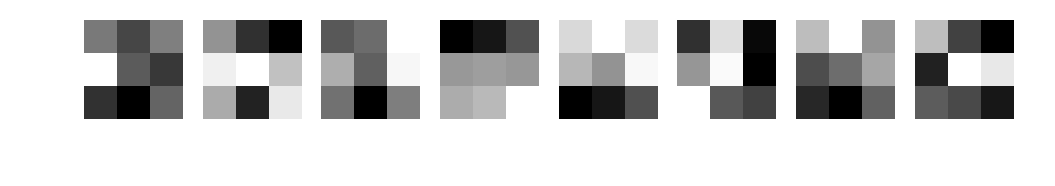

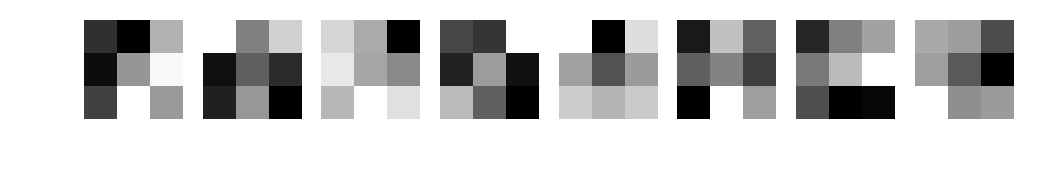

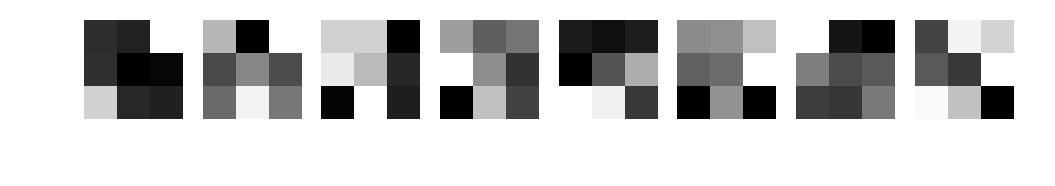

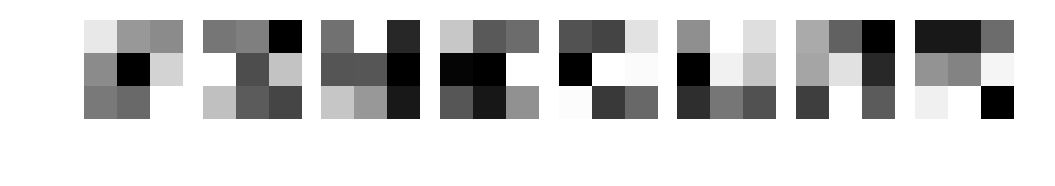

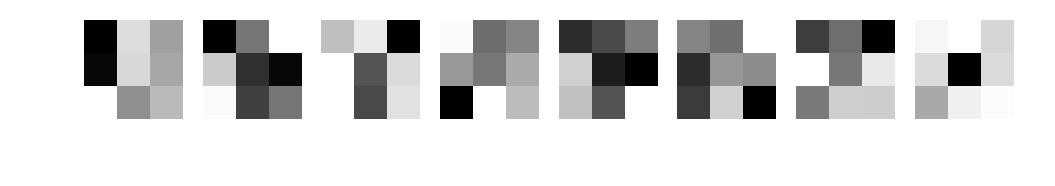

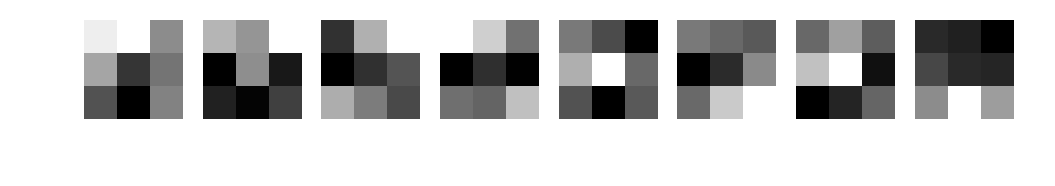

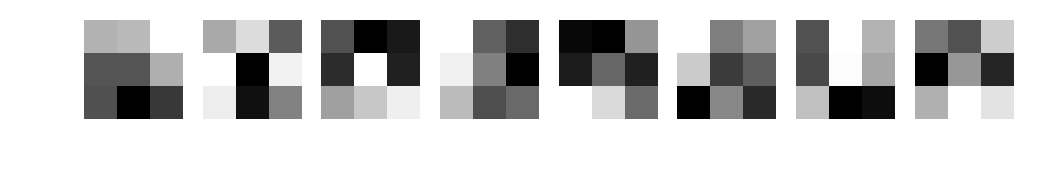

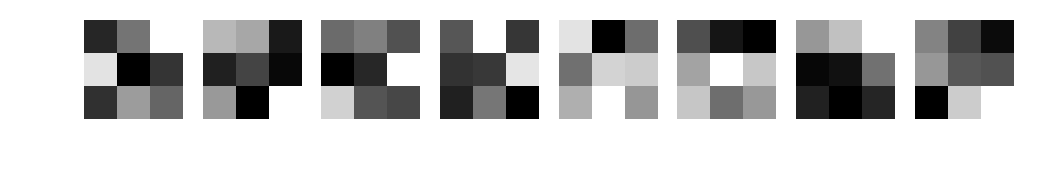

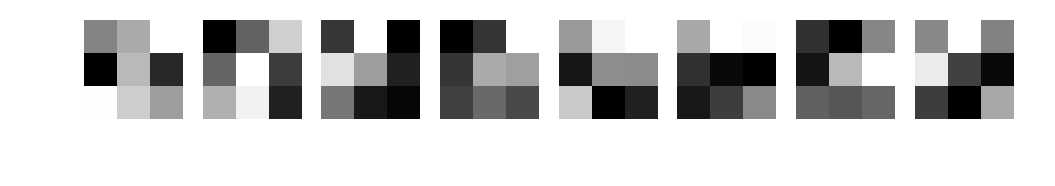

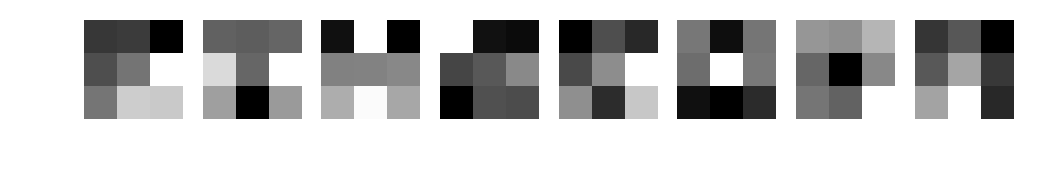

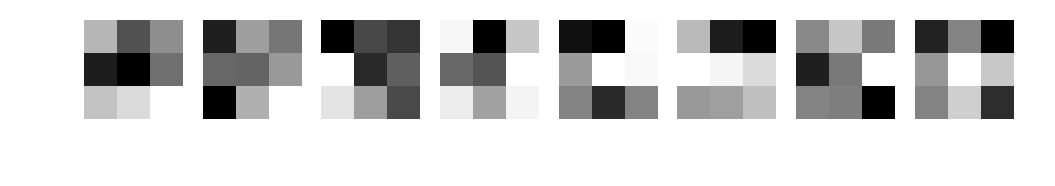

In [69]:
plot_kernels(model.state_dict()['conv2.weight'])